In [1]:
#Necessary packages
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from math import sqrt
import datetime 
import calendar
import sys

In [2]:
# Load the data from the Excel file
file_path = r'C:\Users\PHIRI003\OneDrive - Wageningen University & Research\Documents\WEcR Internship\Work\Dairy\Merged_data.xlsx'
df = pd.read_excel(file_path, header=0 )

#df.index = df['Date']

In [3]:
# Define the function to create seasonal dummy variables
def SeasonalDummies(df, frequency='M'):
    nT = len(df)  # Number of observations
    startdate = df.index[0]  # Start date of the time series
    datetime = pd.DataFrame(data=pd.date_range(startdate, periods=nT, freq=frequency), columns=["datetime"])
    monthnumber = datetime["datetime"].dt.month  # Extract month numbers
    monthname = pd.DataFrame()  # DataFrame to store month names
    
    for i in range(nT):
        monthname.at[i, 'D'] = calendar.month_name[monthnumber[i]]  # Assign month names based on month numbers
    
    seasdum = pd.get_dummies(monthname)  # Create dummy variables for each month
    seasdum = seasdum.drop('D_January', axis=1)  # Drop January to avoid multicollinearity
    seasdum = seasdum.set_index(df.index)  # Set the index to match the original DataFrame
    seasdum = seasdum.astype(int)
    return seasdum

# Create seasonal dummies
seasdum = SeasonalDummies(df)

# Combine the data with the seasonal dummy variables
df = pd.concat([df, seasdum], axis=1)


In [8]:
#lag length selection
from statsmodels.tsa.api import VAR
selected_data = df[['API', 'PPI', 'CPI']]
#selected_data = df[['API', 'PPI', 'CPI',  'Dairy_Conce'  'CWage_20', 'Oil']]

#model fitting 
model = VAR(selected_data)

#optimal lag length 
lag_order = model.select_order(maxlags=12)  

print(lag_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        14.51       14.57   2.001e+06       14.53
1        4.619      4.858*       101.4       4.716
2        4.481       4.898       88.30       4.650
3        4.402       4.999       81.67       4.645
4       4.292*       5.068      73.22*      4.607*
5        4.340       5.295       76.90       4.728
6        4.408       5.542       82.40       4.868
7        4.427       5.740       84.17       4.960
8        4.381       5.873       80.66       4.987
9        4.317       5.988       75.95       4.996
10       4.341       6.192       78.16       5.093
11       4.433       6.462       86.11       5.257
12       4.493       6.702       92.14       5.390
--------------------------------------------------


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [17]:
# Extract the endogenous variables
endog = model.endog

# Create a DataFrame with variable names
df = pd.DataFrame(endog, columns=model.endog_names)

# Calculate the correlation matrix
corr_matrix = df.corr()

# Print the correlation matrix with variable names
print(corr_matrix)


                  Oil  Silage_PI  Dairy_Conce  CWage_20       API       PPI  \
Oil          1.000000   0.047129     0.263937 -0.232156  0.436070  0.095929   
Silage_PI    0.047129   1.000000     0.844521  0.841824  0.543728  0.900476   
Dairy_Conce  0.263937   0.844521     1.000000  0.807703  0.715143  0.865681   
CWage_20    -0.232156   0.841824     0.807703  1.000000  0.415133  0.839613   
API          0.436070   0.543728     0.715143  0.415133  1.000000  0.581181   
PPI          0.095929   0.900476     0.865681  0.839613  0.581181  1.000000   
CPI         -0.116569   0.887612     0.848419  0.948429  0.533604  0.937244   

                  CPI  
Oil         -0.116569  
Silage_PI    0.887612  
Dairy_Conce  0.848419  
CWage_20     0.948429  
API          0.533604  
PPI          0.937244  
CPI          1.000000  


In [4]:
#Create a break dummy
break_date = '2021-09-01'
df['break_dummy'] = (df['Date']>= break_date).astype(int)

#create a trend variable
df['trend'] = range(1, len(df) + 1)  

#Create differenced exogenous lags
columns = ['Oil',  'Silage_PI', 'Dairy_Conce', 'CWage_20', 'break_dummy', 'API', 'PPI','CPI']

for column in columns:
    df[f'd_{column}'] = df[column].diff()

In [10]:
from statsmodels.tsa.vector_ar.vecm import VECM
import re

df.dropna(inplace = True)

#Define endog and exog variables
X = df[[ 'd_Oil',  'd_Dairy_Conce', 'd_CWage_20', 'break_dummy', 'D_April', 'D_August', 'D_December', 'D_February',  'D_July',  'D_June',  'D_March', 'D_May', 'D_September', 'D_October', 'D_November']] 
#X = sm.add_constant(X)
Y = df[['API', 'PPI','CPI']] 

exog_names = ['d_Oil', 'd_Dairy_Conce', 'd_CWage_20', 'break_dummy', 
             'D_April', 'D_August', 'D_December', 
              'D_February', 'D_July', 'D_June', 'D_March', 'D_May', 'D_September', 
              'D_October', 'D_November']

def rename_exog_variables(summary_text, exog_names):
    # Create a mapping from 'exogX' to actual variable names
    exog_map = {f'exog{i+1}': name for i, name in enumerate(exog_names)}

    # Replace the exogX in the summary text with the actual names
    for exog, name in exog_map.items():
        summary_text = re.sub(r'\b{}\b'.format(exog), name, summary_text)
    
    return summary_text

# Fit the VECM model
vecm = VECM(endog=Y, exog=X, k_ar_diff=4, coint_rank=1)  
vecm_fit = vecm.fit()

#summary as a string
summary_str = vecm_fit.summary().as_text()

# Rename exog variables
renamed_summary = rename_exog_variables(summary_str, exog_names)

# Print summary
print(renamed_summary)

Det. terms outside the coint. relation & lagged endog. parameters for equation API
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
d_Oil          0.0104      0.024      0.427      0.669      -0.037       0.058
d_Dairy_Conce          0.2986      0.180      1.657      0.097      -0.055       0.652
d_CWage_20         -2.1414      1.235     -1.734      0.083      -4.562       0.279
break_dummy          3.7586      1.496      2.512      0.012       0.826       6.691
D_April          3.8451      2.021      1.902      0.057      -0.116       7.807
D_August          5.9076      2.011      2.938      0.003       1.967       9.848
D_December         -2.0789      1.821     -1.142      0.254      -5.648       1.490
D_February          2.3711      1.771      1.339      0.181      -1.100       5.842
D_July          6.5912      1.788      3.687      0.000       3.087      10.095
D_June       

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Length of Y: 159
Length of fittedvalues: 159


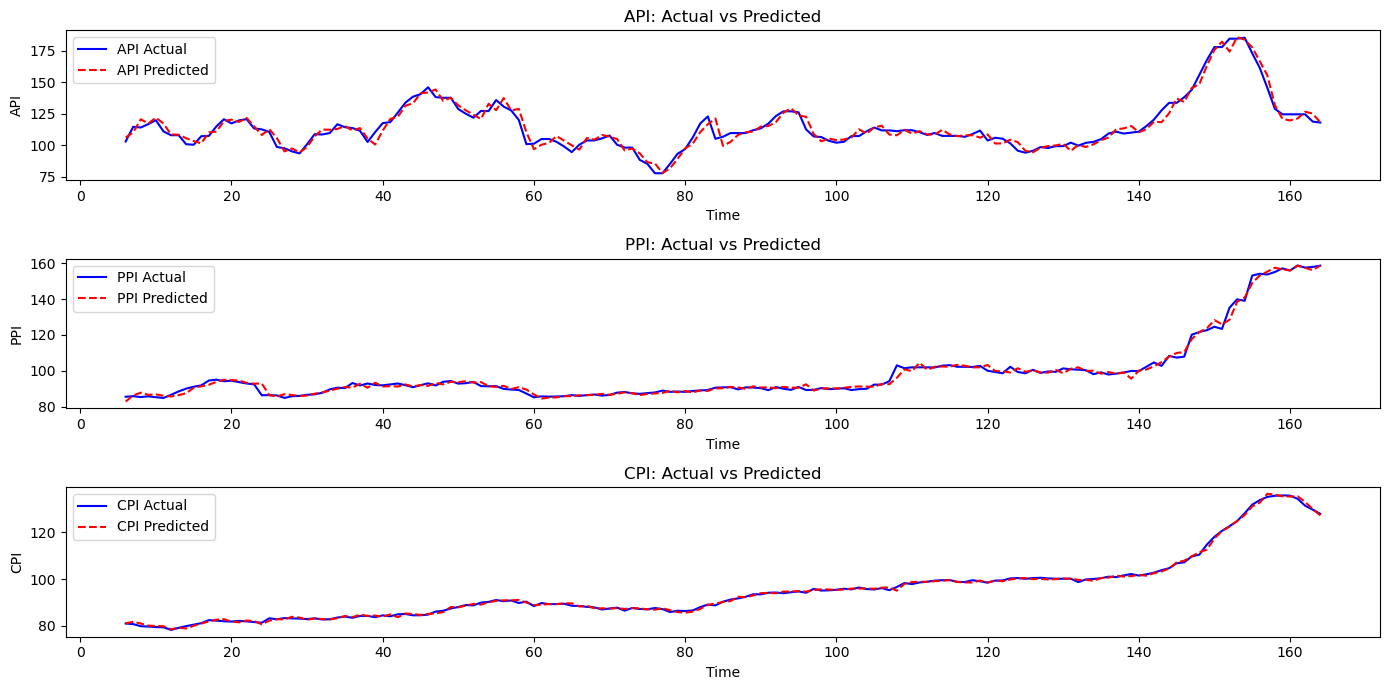

In [8]:
# Getting and plotting the predicted values
# removing the first 5 observations lost in lags and differencing
adjusted_Y = Y.iloc[5:] 

# Checking the lengths of Y2 and fitted values for consistency
print(f"Length of Y: {len(adjusted_Y)}")
print(f"Length of fittedvalues: {len(vecm_fit.fittedvalues)}")

predicted_df = pd.DataFrame(vecm_fit.fittedvalues, columns=adjusted_Y .columns)
predicted_df.index = adjusted_Y.index # Align the index with the actual data for comparison

# Combining actual and predicted values and renaming the columns
comparison_df = pd.concat([adjusted_Y, predicted_df], axis=1)
comparison_df.columns = ['API_Actual','PPI_Actual', 'CPI_Actual', 'API_Predicted', 'PPI_Predicted', 'CPI_Predicted']

import matplotlib.pyplot as plt

# Plotting the actual vs predicted values
plt.figure(figsize=(14, 7))

# Plot for API
plt.subplot(3, 1, 1)
plt.plot(comparison_df.index, comparison_df['API_Actual'], label='API Actual', color='blue')
plt.plot(comparison_df.index, comparison_df['API_Predicted'], label='API Predicted', color='red', linestyle='--')
plt.title('API: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('API')
plt.legend()

# Plot for PPI
plt.subplot(3, 1, 2)
plt.plot(comparison_df.index, comparison_df['PPI_Actual'], label='PPI Actual', color='blue')
plt.plot(comparison_df.index, comparison_df['PPI_Predicted'], label='PPI Predicted', color='red', linestyle='--')
plt.title('PPI: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('PPI')
plt.legend()

# Plot for CPI
plt.subplot(3, 1, 3)
plt.plot(comparison_df.index, comparison_df['CPI_Actual'], label='CPI Actual', color='blue')
plt.plot(comparison_df.index, comparison_df['CPI_Predicted'], label='CPI Predicted', color='red', linestyle='--')
plt.title('CPI: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.legend()

plt.savefig('Fitted_Plots.png')
plt.tight_layout()
plt.show()



In [38]:
from statsmodels.stats.diagnostic import acorr_ljungbox

#  Ljung-Box test for autocorrelation
for i in range(vecm_fit.resid.shape[1]):
    print(f"Ljung-Box Test for Residuals of Equation {i+1}:")
    ljung_box_results = acorr_ljungbox(vecm_fit.resid[:, i], lags=[1, 5, 8])
    print(ljung_box_results)
    print("\n")

Ljung-Box Test for Residuals of Equation 1:
    lb_stat  lb_pvalue
1  0.193102   0.660347
5  0.834941   0.974751
8  5.344056   0.720249


Ljung-Box Test for Residuals of Equation 2:
    lb_stat  lb_pvalue
1  0.003534   0.952596
5  0.431394   0.994421
8  5.281728   0.727084


Ljung-Box Test for Residuals of Equation 3:
    lb_stat  lb_pvalue
1  0.171212   0.679037
5  3.688994   0.595003
8  7.034984   0.532863




In [40]:
from statsmodels.stats.diagnostic import het_arch

# ARCH test for heteroscedasticity for each equation
arch_test_results = [het_arch(resid) for resid in vecm_fit.resid.T]

# DataFrame to store the results
columns = ['Test Statistic', 'P-value', 'Lags used']
results_df = pd.DataFrame(columns=columns)

# DataFrame with the results
for i, result in enumerate(arch_test_results):
    test_statistic, p_value, lags_used, _ = result
    results_df.loc[f'Equation {i+1}'] = [test_statistic, p_value, lags_used]

# Display the results
print(results_df)

            Test Statistic   P-value  Lags used
Equation 1       14.389373  0.155960   1.475168
Equation 2        5.371211  0.865043   0.516071
Equation 3       10.775145  0.375303   1.075762


In [9]:
#Differenced VAR model
df.dropna(inplace = True)

#Define endog and exog variables
X2 = df[[ 'd_Oil', 'd_Dairy_Conce', 'd_CWage_20', 'd_break_dummy', 'D_April', 'D_August', 'D_December', 'D_February',  'D_July',  'D_June',  'D_March', 'D_May', 'D_September', 'D_October', 'D_November']] 
#X = sm.add_constant(X)
Y2 = df[['d_API', 'd_PPI','d_CPI']] 

# Fit the VAR model
var = VAR(Y2, X2)  
var_fit = var.fit(4)

# Print the modified summary
print(var_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 23, Aug, 2024
Time:                     19:13:27
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    5.60984
Nobs:                     160.000    HQIC:                   4.61671
Log likelihood:          -909.108    FPE:                    51.9284
AIC:                      3.93772    Det(Omega_mle):         31.5050
--------------------------------------------------------------------
Results for equation d_API
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -3.011628         1.988192           -1.515           0.130
d_Oil                 0.008876         0.027186            0.326           0.744
d_Silage_PI           0.052772         0.112270            0

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<Figure size 1400x1200 with 0 Axes>

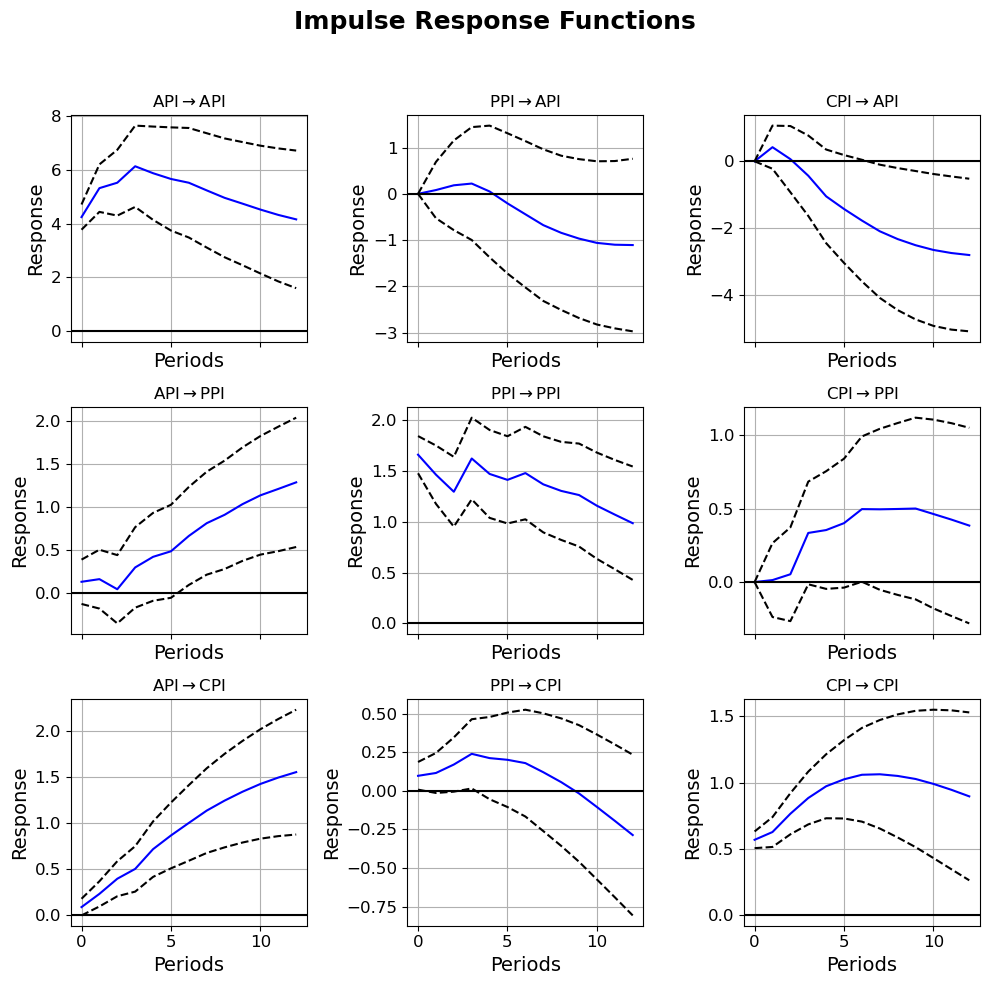

In [22]:
import matplotlib.pyplot as plt

# Generating impulse response functions
irf = vecm_fit.irf(periods=12)

# Plot the IRFs with confidence intervals
fig = plt.figure(figsize=(14, 12))
irf.plot(orth=True, plot_stderr=True)  # CI

plt.suptitle('Impulse Response Functions', fontsize=18, fontweight='bold')

# Customizing each subplot in the figure
for ax in plt.gcf().axes:
    ax.set_xlabel('Periods', fontsize=14)
    ax.set_ylabel('Response', fontsize=14)
    ax.grid(True) 
    ax.xaxis.set_tick_params(labelsize=12) 
    ax.yaxis.set_tick_params(labelsize=12)

# Adjust layout to remove overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save and show the plot
plt.savefig('improved_irf_plot.png', bbox_inches='tight') 
plt.show()


In [5]:
# Granger Causality Test Function
from statsmodels.tsa.stattools import grangercausalitytests

def granger_causality_test(df, var1, var2, max_lag):
    print(f'Granger Causality Test: {var1} causes {var2}')
    test_result = grangercausalitytests(df[[var2, var1]], max_lag, verbose=True)
    return test_result

# Usage
max_lag = 4

#On CPI
granger_causality_test(df, 'PPI', 'CPI', max_lag)
granger_causality_test(df, 'API', 'CPI', max_lag)
granger_causality_test(df, 'Oil', 'CPI', max_lag)
granger_causality_test(df, 'Silage_PI', 'CPI', max_lag)
granger_causality_test(df, 'Dairy_Conce', 'CPI', max_lag)
granger_causality_test(df, 'CWage_20', 'CPI', max_lag)

Granger Causality Test: PPI causes CPI

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1148  , p=0.7352  , df_denom=161, df_num=1
ssr based chi2 test:   chi2=0.1169  , p=0.7324  , df=1
likelihood ratio test: chi2=0.1169  , p=0.7324  , df=1
parameter F test:         F=0.1148  , p=0.7352  , df_denom=161, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0945  , p=0.3372  , df_denom=158, df_num=2
ssr based chi2 test:   chi2=2.2582  , p=0.3233  , df=2
likelihood ratio test: chi2=2.2427  , p=0.3258  , df=2
parameter F test:         F=1.0945  , p=0.3372  , df_denom=158, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1029  , p=0.1021  , df_denom=155, df_num=3
ssr based chi2 test:   chi2=6.5935  , p=0.0860  , df=3
likelihood ratio test: chi2=6.4628  , p=0.0911  , df=3
parameter F test:         F=2.1029  , p=0.1021  , df_denom=155, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions shou

{1: ({'ssr_ftest': (1.5964606131820434, 0.2082320486429909, 161.0, 1),
   'ssr_chi2test': (1.6262083264711498, 0.2022282933994573, 1),
   'lrtest': (1.618198569099377, 0.20334315444904255, 1),
   'params_ftest': (1.5964606131823025, 0.2082320486429554, 161.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (7.023642024685514, 0.001196002242631778, 158.0, 2),
   'ssr_chi2test': (14.491818354730869, 0.0007130855367419785, 2),
   'lrtest': (13.883413063041473, 0.0009666186236930769, 2),
   'params_ftest': (7.023642024685799, 0.0011960022426314696, 158.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (6.847812929746523, 0.00023109525830027002, 155.0, 3),
   'ssr_chi2test': (21.471206992624584, 8.402864283572977e-05, 3),
   'lrtest': (20.16274839223695, 0.0001570566877236027, 3),
   'params_ftest': (6.847812929745817, 0.00023109525830047642, 155.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
   

In [6]:
#On PPI
granger_causality_test(df, 'CPI', 'PPI', max_lag)
granger_causality_test(df, 'API', 'PPI', max_lag)
granger_causality_test(df, 'Oil', 'PPI', max_lag)
granger_causality_test(df, 'Silage_PI', 'PPI', max_lag)
granger_causality_test(df, 'Dairy_Conce', 'PPI', max_lag)
granger_causality_test(df, 'CWage_20', 'PPI', max_lag)

Granger Causality Test: CPI causes PPI

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3368  , p=0.0221  , df_denom=161, df_num=1
ssr based chi2 test:   chi2=5.4363  , p=0.0197  , df=1
likelihood ratio test: chi2=5.3481  , p=0.0207  , df=1
parameter F test:         F=5.3368  , p=0.0221  , df_denom=161, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.6012  , p=0.0045  , df_denom=158, df_num=2
ssr based chi2 test:   chi2=11.5569 , p=0.0031  , df=2
likelihood ratio test: chi2=11.1656 , p=0.0038  , df=2
parameter F test:         F=5.6012  , p=0.0045  , df_denom=158, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.4578  , p=0.0014  , df_denom=155, df_num=3
ssr based chi2 test:   chi2=17.1128 , p=0.0007  , df=3
likelihood ratio test: chi2=16.2680 , p=0.0010  , df=3
parameter F test:         F=5.4578  , p=0.0014  , df_denom=155, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions shou

{1: ({'ssr_ftest': (1.540412959991032, 0.2163616762786926, 161.0, 1),
   'ssr_chi2test': (1.56911630707161, 0.21033539375670474, 1),
   'lrtest': (1.5616573646930192, 0.21142271513837307, 1),
   'params_ftest': (1.5404129599906813, 0.2163616762787418, 161.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.9260918257127735, 0.14912257100042572, 158.0, 2),
   'ssr_chi2test': (3.974088197356736, 0.13710008140116126, 2),
   'lrtest': (3.9264155694675082, 0.14040730136284027, 2),
   'params_ftest': (1.9260918257127368, 0.14912257100043239, 158.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.163742080689028, 0.09454316228100118, 155.0, 3),
   'ssr_chi2test': (6.784378394934629, 0.07909733186976046, 3),
   'lrtest': (6.646163010100054, 0.08407303515195529, 3),
   'params_ftest': (2.1637420806892655, 0.0945431622809727, 155.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0.

In [ ]:
#On API
granger_causality_test(df, 'CPI', 'API', max_lag)
granger_causality_test(df, 'PPI', 'API', max_lag)
granger_causality_test(df, 'Oil', 'API', max_lag)
granger_causality_test(df, 'Silage_PI', 'API', max_lag)
granger_causality_test(df, 'Dairy_Conce', 'API', max_lag)
granger_causality_test(df, 'CWage_20', 'API', max_lag)

In [22]:
# Factor Error Variance Decomposition
from statsmodels.tsa.api import VAR

var_model = VAR(vecm_fit.model.endog)
#var_fit = var_model.fit(maxlags=vecm_fit.k_ar_diff)

n_lags = vecm_fit.k_ar

var_fit = var_model.fit(maxlags=n_lags)

# variance decomposition
fevd = var_fit.fevd(periods=12)

#  results
print(fevd.summary())


FEVD for y1
            y1        y2        y3
0     1.000000  0.000000  0.000000
1     0.994203  0.005412  0.000386
2     0.989253  0.010449  0.000298
3     0.983936  0.012951  0.003113
4     0.970295  0.018615  0.011089
5     0.953394  0.024903  0.021703
6     0.933439  0.030991  0.035570
7     0.911710  0.037500  0.050790
8     0.892203  0.042664  0.065133
9     0.875347  0.046376  0.078277
10    0.861634  0.048719  0.089647
11    0.851220  0.049593  0.099187

FEVD for y2
            y1        y2        y3
0     0.008183  0.991817  0.000000
1     0.026292  0.972841  0.000867
2     0.043687  0.944985  0.011328
3     0.080409  0.900154  0.019437
4     0.124738  0.845556  0.029707
5     0.159542  0.794763  0.045694
6     0.198893  0.741020  0.060087
7     0.234806  0.687720  0.077473
8     0.262136  0.641337  0.096527
9     0.288533  0.596690  0.114777
10    0.310918  0.554720  0.134362
11    0.329477  0.516809  0.153715

FEVD for y3
            y1        y2        y3
0     0.048631  0